## Clustering Project: Drivers of Error in Zillow Zestimates

Data Science Team Members: Gabby Broussard and Barbara Marques

#### Project Summary:

Our team has been asked to analyze Zillow data on single unit/single family properties with transaction dates in 2017 to discover the drivers of errors in Zillow's zestimates. 

Data Source: Zillow database on Codeup's data server.

#### Project Goals:
- Build out caching in your python scripts to store the data locally as a csv in order to speed up future data acquisition.
- Deliver a notebook presentation of methods used to isolate drivers of error in Zillow Zestimates

#### Initial Questions: 



<a id='back'></a>
### Quick Links to Sections within this Notebook

- [Acquire Data](#AD)
- [Prepare Data](#PD)
- [Split Data](#SD)
- [Explore Data](#Explore)
- [Hypothesis Testing](#Hypo)
- [Scale Data](#Scale)
- [Create a Baseline Model](#Baseline)
- [Model Data (train & validate)](#Model)
- [Model on Test Data](#Test)
- [Model Visualizations](#Visual)
- [Recommendations & Key Takeaways](#Concl)

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle
from acquire import get_zillow_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression 
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', 80)

<a id='AD'></a>
## Acquire
[back to top](#back)

In [2]:
acquired_zillow =get_zillow_data()

In [3]:
acquired_zillow.shape

(77575, 69)

In [4]:
acquired_zillow.describe()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,77575.000000,7.757500e+04,7.757500e+04,25006.000000,206.000000,50.000000,77575.000000,77575.000000,15.000000,49809.000000,76960.000000,614.0,6035.000000,77375.000000,73920.000000,42.000000,3027.000000,6035.000000,386.000000,77575.000000,8287.000000,76960.000000,25517.000000,25517.000000,1539.0,49570.000000,7.757500e+04,7.757500e+04,6.931800e+04,16173.0,869.000000,465.0,1074.0,15078.0,77575.000000,7.757500e+04,76103.000000,77575.000000,30973.000000,77525.000000,77575.00000,50.0,10105.000000,222.000000,50703.000000,2393.000000,70.000000,77306.000000,17596.000000,172.0,7.746000e+04,7.757400e+04,77575.0,7.757300e+04,77570.000000,2900.000000,7.732800e+04,77575.000000
mean,38787.000000,1.495352e+06,1.300630e+07,1.812045,7.388350,679.720000,2.298518,3.053252,3.933333,6.533779,2.316385,66.0,1366.198012,1784.938998,1760.287297,1388.761905,2354.491245,1381.426678,2082.500000,6048.812568,1.191263,2.250104,1.815339,350.055845,1.0,3.921707,3.400837e+07,-1.182037e+08,2.997445e+04,1.0,517.930955,1.0,1.0,1.0,261.824467,6.049123e+07,33683.390392,2534.535933,187730.297162,96586.677033,1.47612,7.0,1.009599,6.040541,1.110309,305.460928,216.385714,1968.610936,1.434246,1.0,1.892815e+05,4.901447e+05,2016.0,3.011453e+05,5995.821528,14.088276,6.049666e+13,0.016802
std,22394.117903,8.609703e+05,3.478021e+06,2.965823,2.734542,689.703546,0.996700,1.140440,0.258199,1.722062,0.979684,0.0,670.803630,954.262540,934.364843,122.220874,1186.985442,725.904022,1240.382784,20.745309,0.491031,0.966479,0.588329,261.651602,0.0,3.594804,2.652878e+05,3.593826e+05,1.233076e+05,0.0,156.569664,0.0,0.0,0.0,5.141701,2.058768e+05,47212.856528,801.449852,165045.226146,3793.648751,2.82360,0.0,0.118578,0.557285,1.169967,238.735241,190.177514,23.793197,0.544518,0.0,2.304137e+05,6.538022e+05,0.0,4.927287e+05,7628.869090,2.181281,1.533376e+12,0.170743
min,0.000000,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.00000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,19393.500000,7.521050e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.00000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.418200e+04,2.068985e+05,2016.0,8.529300e+04,2712.630000,14.000000,6.037311e+13,-0.024311
50%,38787.000000,1.498195e+06,1.253053e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000

In [5]:
null_counts = acquired_zillow.isnull().sum().sort_values(ascending=False)
null_counts

buildingclassdesc       77560
buildingclasstypeid     77560
finishedsquarefeet13    77533
storydesc               77525
basementsqft            77525
                        ...  
assessmentyear              0
logerror                    0
transactiondate             0
propertylandusedesc         0
Unnamed: 0                  0
Length: 69, dtype: int64

### Takeaways:
##### There are numerous null values that need to be handled
#### Columns with too many nulls need to be dropped from the data frame.
##### There are many outliers so they either need to be removed or handled by using a RobustScaler when scaling the data.

<a id='PD'></a>
## Prepare

[back to top](#back)

In [6]:
df= wrangle.wrangle_zillow()

In [7]:
df.head() 

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,age_bin,taxrate,acres,acres_bin,tax_value_bin,land_tax_value_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,2.0,3.0,2107.0,6037,34222559.0,-118617387.0,45.0,249655.0,624139.0,374484.0,7659.36,-0.007357,40-50,1.227188,0.210239,0.2,"$650,000","$450,000",0.5,118.488372,0.4,40.891461,20-49,0.666667,1
1,2.0,4.0,1882.0,6037,34220261.0,-118616409.0,45.0,253000.0,660000.0,407000.0,8123.91,0.021066,40-50,1.230895,0.207415,0.2,"$900,000","$450,000",0.4,134.431456,0.4,45.047039,20-49,0.500000,1
2,2.0,4.0,1882.0,6037,34222491.0,-118616854.0,45.0,257591.0,542923.0,285332.0,6673.24,0.077174,40-50,1.229132,0.224977,0.2,"$550,000","$350,000",0.4,136.870882,0.4,29.115510,20-49,0.500000,1
3,2.0,3.0,1477.0,6037,34221864.0,-118615739.0,57.0,57968.0,78031.0,20063.0,1116.46,-0.041238,50-60,1.430790,0.259068,0.3,"< $80,000","< $50,000",0.3,39.247123,0.1,1.777847,1,0.666667,1
4,2.0,4.0,1918.0,6037,34220619.0,-118615253.0,57.0,167869.0,415459.0,247590.0,5239.85,-0.009496,50-60,1.261220,0.258012,0.3,"$450,000","$250,000",0.4,87.522941,0.3,22.029540,20-49,0.500000,1


In [8]:
# look at the first 5 rows of our new dataframe, transposed
df.head().T

,0,1,2,3,4
bathrooms,2,2,2,2,2
bedrooms,3,4,4,3,4
square_feet,2107,1882,1882,1477,1918
fips,6037,6037,6037,6037,6037
latitude,3.42226e+07,3.42203e+07,3.42225e+07,3.42219e+07,3.42206e+07
longitude,-1.18617e+08,-1.18616e+08,-1.18617e+08,-1.18616e+08,-1.18615e+08
age,45,45,45,57,57
structure_tax_value,249655,253000,257591,57968,167869
tax_value,624139,660000,542923,78031,415459
land_tax_value,374484,407000,285332,20063,247590


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69349 entries, 0 to 77549
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bathrooms                  69349 non-null  float64 
 1   bedrooms                   69349 non-null  float64 
 2   square_feet                69349 non-null  float64 
 3   fips                       69349 non-null  int64   
 4   latitude                   69349 non-null  float64 
 5   longitude                  69349 non-null  float64 
 6   age                        69349 non-null  float64 
 7   structure_tax_value        69349 non-null  float64 
 8   tax_value                  69349 non-null  float64 
 9   land_tax_value             69349 non-null  float64 
 10  taxamount                  69349 non-null  float64 
 11  logerror                   69349 non-null  float64 
 12  age_bin                    69349 non-null  category
 13  taxrate                    6934

In [10]:
#There are no remaining null values

df.isna().sum().sum()

2367

### Creating some new features:
- bins for: age, square feet
- tax rate
- bath/bed ratio:  (bathroom count / bedroom count)
- acres (lotsizesquarefeet/43560)
- dollar per square foot
- within city of Los Angeles


In [11]:
df.head().T

,0,1,2,3,4
bathrooms,2,2,2,2,2
bedrooms,3,4,4,3,4
square_feet,2107,1882,1882,1477,1918
fips,6037,6037,6037,6037,6037
latitude,3.42226e+07,3.42203e+07,3.42225e+07,3.42219e+07,3.42206e+07
longitude,-1.18617e+08,-1.18616e+08,-1.18617e+08,-1.18616e+08,-1.18615e+08
age,45,45,45,57,57
structure_tax_value,249655,253000,257591,57968,167869
tax_value,624139,660000,542923,78031,415459
land_tax_value,374484,407000,285332,20063,247590


In [12]:
df.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,bath_bed_ratio,cola
count,69349.000000,69349.000000,69349.000000,69349.000000,6.934900e+04,6.934900e+04,69349.000000,6.934900e+04,6.934900e+04,6.934900e+04,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000,69349.000000
mean,2.251821,3.010368,1730.667609,6049.348988,3.400252e+07,-1.181933e+08,47.974419,1.801867e+05,4.655554e+05,2.853687e+05,5675.169086,0.016308,1.302603,0.556232,0.208192,0.352691,99.144978,0.305529,40.628768,0.781380,0.229664
std,0.899962,0.984725,851.761626,20.857160,2.680495e+05,3.612545e+05,22.967324,1.762367e+05,4.551819e+05,3.270891e+05,5275.911173,0.164781,0.324705,1.567698,0.139998,0.186598,59.587759,0.145831,60.107456,0.287038,0.420620
min,1.000000,1.000000,500.000000,6037.000000,3.333953e+07,-1.194753e+08,1.000000,4.400000e+01,3.254000e+03,1.196000e+03,19.920000,-4.655420,0.009372,0.005418,0.000000,0.000000,0.039833,0.000000,0.005405,0.200000,0.000000
25%,2.000000,2.000000,1166.000000,6037.000000,3.380398e+07,-1.184091e+08,31.000000,8.313800e+04,2.034610e+05,8.253100e+04,2670.240000,-0.023758,1.162138,0.137741,0.100000,0.200000,62.566210,0.200000,6.317517,0.600000,0.000000
50%,2.000000,3.000000,1508.000000,6037.000000,3.401297e+07,-1.181627e+08,47.000000,1.338650e+05,3.550000e+05,2.031950e+05,4378.260000,0.006511,1.225351,0.167883,0.200000,0.400000,91.215385,0.300000,25.053753,0.750000,0.000000
75%,3.000000,4.000000,2048.000000,6059.000000,3.417439e+07,-1.179127e+08,63.000000,2.131850e+05,5.627710e+05,3.665770e+05,6772.530000,0.038048,1.336699,0.242815,0.200000,0.500000,123.867302,0.400000,51.414467,1.000000,0.000000
max,7.000000,7.000000,8909.000000,6111.000000,3.481877e+07,-1.175723e+08,139.000000,3.097672e+06,4.993132e+06,4.847224e+06,72122.200000,3.394544,9.805110,19.796350,0.700000,0.900000,1444.221106,0.900000,1604.525311,3.000000,1.000000


(array([2.0000e+00, 1.0000e+00, 2.3000e+01, 1.7000e+01, 1.3000e+02,
        6.5827e+04, 3.1170e+03, 1.2300e+02, 9.7000e+01, 1.2000e+01]),
 array([-4.65542038, -3.85042393, -3.04542749, -2.24043104, -1.4354346 ,
        -0.63043816,  0.17455829,  0.97955473,  1.78455118,  2.58954762,
         3.39454407]),
 <a list of 10 Patch objects>)

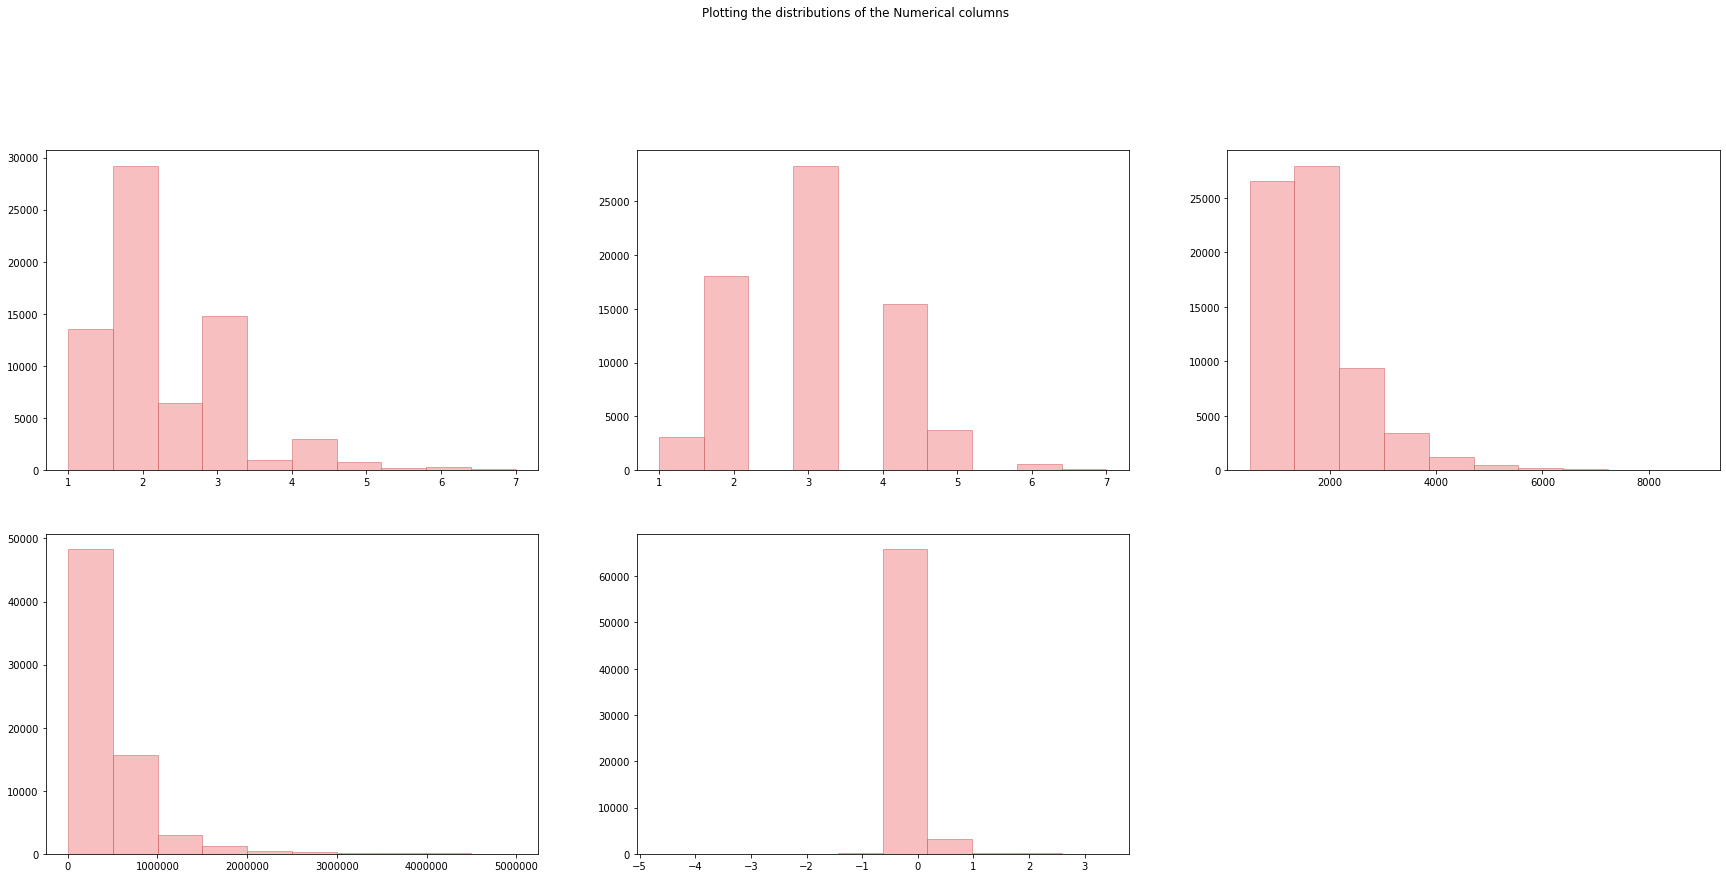

In [13]:
plt.figure(figsize=(30, 20))

plt.suptitle("Plotting the distributions of the Numerical columns")
# row, columns, index
plt.subplot(3, 3, 1)
plt.hist(df.bathrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 2)
plt.hist(df.bedrooms, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 3)
plt.hist(df.square_feet, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 4)
plt.hist(df.tax_value, edgecolor='indianred', alpha=0.5, color='lightcoral')
plt.subplot(3, 3, 5)
plt.hist(df.logerror, edgecolor='indianred', alpha=0.5, color='lightcoral')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69349 entries, 0 to 77549
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bathrooms                  69349 non-null  float64 
 1   bedrooms                   69349 non-null  float64 
 2   square_feet                69349 non-null  float64 
 3   fips                       69349 non-null  int64   
 4   latitude                   69349 non-null  float64 
 5   longitude                  69349 non-null  float64 
 6   age                        69349 non-null  float64 
 7   structure_tax_value        69349 non-null  float64 
 8   tax_value                  69349 non-null  float64 
 9   land_tax_value             69349 non-null  float64 
 10  taxamount                  69349 non-null  float64 
 11  logerror                   69349 non-null  float64 
 12  age_bin                    69349 non-null  category
 13  taxrate                    6934

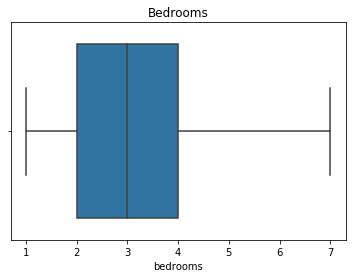

In [15]:
### Checking for Outliers:
sns.boxplot(df['bedrooms'])
plt.title('Bedrooms')
plt.show()

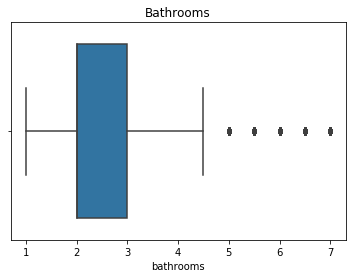

In [16]:
sns.boxplot(df['bathrooms'])
plt.title('Bathrooms')
plt.show()

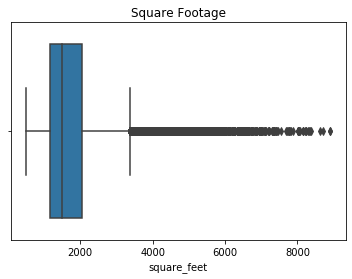

In [17]:
sns.boxplot(df['square_feet'])
plt.title('Square Footage')
plt.show()

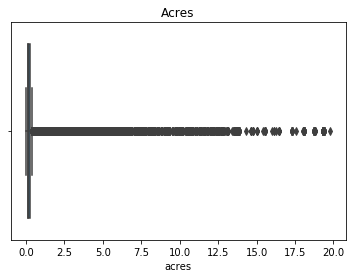

In [18]:
sns.boxplot(df['acres'])
plt.title('Acres')
plt.show()

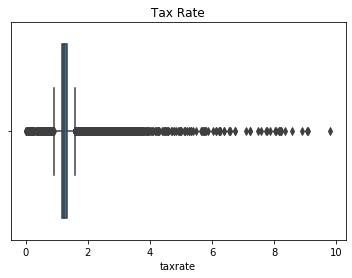

In [19]:
sns.boxplot(df['taxrate'])
plt.title('Tax Rate')
plt.show()

### Takeaways:  

Removing Outliers:

Remove extremes in bedrooms and baths (KEEP only 1-7 baths and 1-7 bedrooms)

remove square feet > 9000

remove lot size (acres) > 20 

Remove tax rate > 10% 

## Explore

<a id='SD'></a>
#### Splitting Data

[back to top](#back)

In [20]:
train_validate, test = train_test_split(df, test_size=.30, random_state=123)
train, validate = train_test_split(train_validate, test_size=.20, random_state=123)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (38835, 25)
validate observations:  (9709, 25)
test observations:  (20805, 25)


### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Text(0.5, 1.0, 'County v. Log Error')

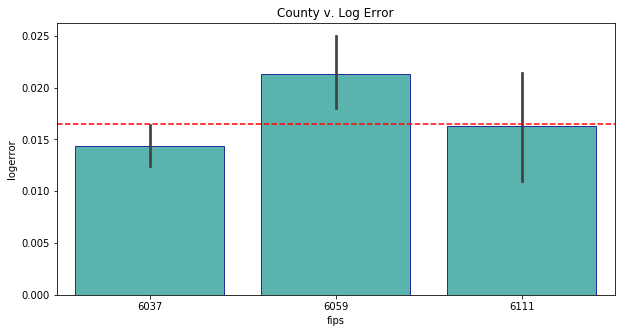

In [21]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.fips, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('County v. Log Error')

### Hypothesis Testing - ANOVA

Ho: There is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County.
Ha: Logerror is significantly different among the counties of LA County, Orange County and Ventura County.

In [22]:
α = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6111], train.logerror[train.fips == 6037], train.logerror[train.fips == 6059])
F, p

(6.77954297552004, 0.00113814033427514)

In [23]:
null_hypothesis = 'there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)


We reject the null hypothesis that there is no significant difference in logerror for properties in LA County vs Orange County vs Ventura County


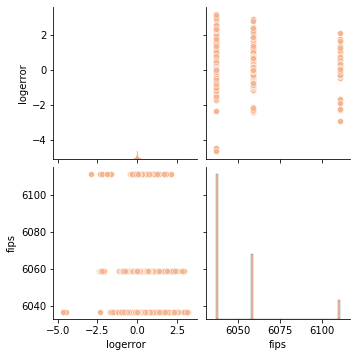

In [24]:
sns.set_palette("rocket_r")
sns.pairplot(train[['logerror', 'fips']])  

### Hypothesis Testing - Pearson R Correlation


𝐻0: There is no difference in log error based on a properties square footage. <br>
𝐻𝑎: A properties square footage less than 2800 square footage have a lower log error than larger properties. 

In [25]:
n = train.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval
null_hypothesis = "there is no difference in log error based on a properties square footage."

In [26]:
x1 = train[train.square_feet >= 2800].logerror
x2 = train[train.square_feet < 2800].logerror

In [27]:
t, p= stats.ttest_ind(x1, x2)

In [28]:
if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

We reject the null hypothesis that there is no difference in log error based on a properties square footage.


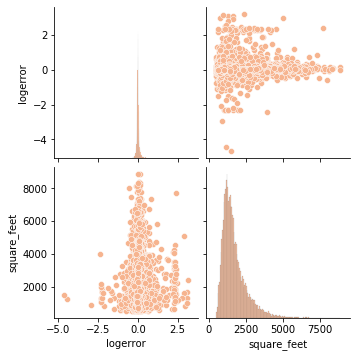

In [29]:
sns.set_palette("rocket_r")
sns.pairplot(train[['logerror', 'square_feet']])  

Text(0.5, 1.0, 'Acres v. Log Error')

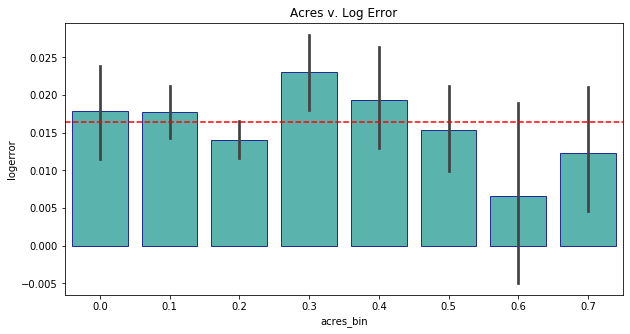

In [30]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.acres_bin, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Acres v. Log Error')

Text(0.5, 1.0, 'Lot Dollar Per Square Footage v. Log Error')

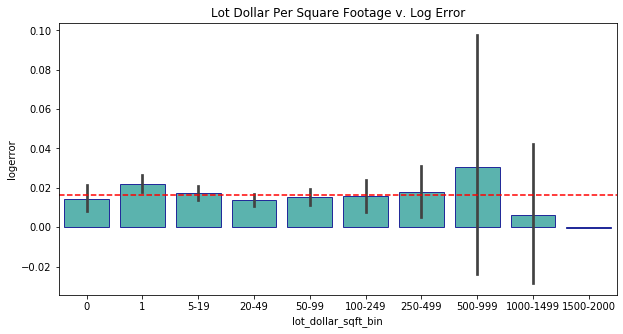

In [31]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.lot_dollar_sqft_bin, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('Lot Dollar Per Square Footage v. Log Error')

Text(0.5, 1.0, 'County v. Log Error')

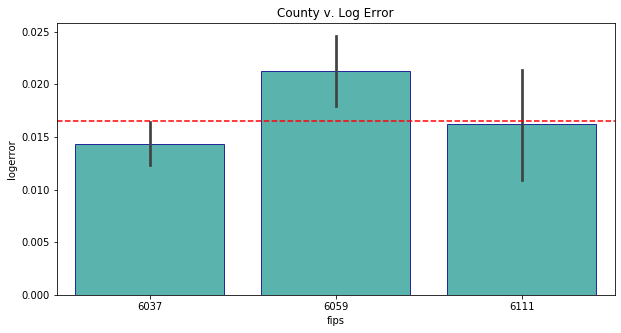

In [32]:
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.fips,train.logerror, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate =(train.logerror.mean())
p = plt.axhline(overall_rate, ls='--', color='red')
plt.title('County v. Log Error')

### Takeaways: 
- Hypothesis testing shows: There is a relationship between counties and log error.
- Hypothesis testing shows: There correlation between square footage and log error.
- Visualization shows: as dollar per square foot of land price increases, properties as a whole are undervalued by Zillow.
- Visualization shows: as acreage of land increases, properties as a whole are overvalued by Zillow.

## Clustering

### Split to create y_train, y_validate, y_test and Scale Data

In [33]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.data_split(df)

In [34]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips', 'latitude', 'longitude',
       'age', 'structure_tax_value', 'tax_value', 'land_tax_value',
       'taxamount', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bath_bed_ratio', 'cola'],
      dtype='object')

In [35]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.scaled_data(X_train, X_validate, X_test, y_train, y_validate, y_test)

## <font color = 'red'> Cluster on All Columns

In [36]:
X = X_train

# Make the kmeans object
kmeans = KMeans(n_clusters=4)

# fit the kmeans model
kmeans.fit(X)

# use the thing
kmeans.predict(X)

array([3, 1, 3, ..., 0, 0, 0], dtype=int32)

In [37]:
X_train.shape, X_validate.shape, X_test.shape

((38835, 16), (16644, 16), (13870, 16))

In [38]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips', 'latitude', 'longitude',
       'age', 'structure_tax_value', 'tax_value', 'land_tax_value',
       'taxamount', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bath_bed_ratio', 'cola'],
      dtype='object')

In [39]:
X_train["cluster_all"] = kmeans.predict(X)
X_validate['cluster_all'] = kmeans.predict(X_validate)
X_test['cluster_all'] = kmeans.predict(X_test)

In [40]:
X.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
0,0.166667,0.333333,0.088894,0.0,0.589381,0.669595,0.456522,0.057297,0.177240,0.175609,0.154379,0.008115,0.109072,0.062633,0.166667,0.0,3
1,0.166667,0.166667,0.100334,0.0,0.555030,0.520939,0.369565,0.041100,0.061868,0.045434,0.052700,0.026685,0.072638,0.005155,0.285714,1.0,1
2,0.166667,0.166667,0.031220,0.0,0.448288,0.525143,0.318841,0.031542,0.083936,0.080044,0.071659,0.010607,0.098198,0.022185,0.285714,0.0,3
3,0.333333,0.500000,0.340562,0.0,0.513403,0.575186,0.449275,0.037221,0.032336,0.011908,0.031440,0.008580,0.026271,0.004116,0.196429,1.0,1
4,0.166667,0.333333,0.111535,0.0,0.590837,0.648049,0.442029,0.016427,0.015817,0.007444,0.012834,0.012647,0.027128,0.001799,0.166667,0.0,3


In [41]:
X.cluster_all.value_counts()

3    15490
0    11214
1     8922
2     3209
Name: cluster_all, dtype: int64

In [42]:
cluster0 = X[X.cluster_all == 0]
cluster1 = X[X.cluster_all == 1]
cluster2 = X[X.cluster_all == 2]
cluster3 = X[X.cluster_all == 3]

In [43]:
cluster0.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.000000,11214.0,11214.0
mean,0.233399,0.353071,0.165558,0.293347,0.249158,0.866739,0.271304,0.061884,0.107594,0.086005,0.086745,0.008171,0.070593,0.039668,0.215658,0.0,0.0
std,0.146767,0.171022,0.114499,0.034042,0.086105,0.073952,0.128177,0.064957,0.098587,0.087011,0.077331,0.007602,0.037560,0.050390,0.088979,0.0,0.0
min,0.000000,0.000000,0.000119,0.000000,0.000000,0.514246,0.007246,0.000000,0.004248,0.000049,0.000000,0.000052,0.000023,0.000004,0.000000,0.0,0.0
25%,0.166667,0.166667,0.087345,0.297297,0.188178,0.809019,0.173913,0.025822,0.051256,0.034406,0.041314,0.005993,0.045475,0.013589,0.151786,0.0,0.0
50%,0.250000,0.333333,0.135546,0.297297,0.245108,0.868578,0.275362,0.041878,0.084320,0.067368,0.067345,0.007980,0.064302,0.026772,0.196429,0.0,0.0
75%,0.333333,0.500000,0.212673,0.297297,0.318606,0.928224,0.369565,0.070971,0.129010,0.109000,0.103962,0.007980,0.090533,0.047702,0.285714,0.0,0.0
max,1.000000,1.000000,1.000000,0.297297,0.591912,1.000000,0.833333,1.000000,1.000000,1.000000,0.807009,0.206709,0.916007,1.000000,1.000000,0.0,0.0


In [44]:
cluster1.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,8922.000000,8922.000000,8922.000000,8922.0,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.000000,8922.0,8922.0
mean,0.203897,0.303519,0.140800,0.0,0.526849,0.555974,0.407162,0.062451,0.102783,0.079624,0.088197,0.040407,0.084503,0.024853,0.224484,1.0,1.0
std,0.163506,0.165311,0.100143,0.0,0.081267,0.059745,0.181522,0.067126,0.107226,0.093117,0.090935,0.095069,0.059012,0.034938,0.121079,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.249683,0.424844,0.007246,0.000028,0.000000,0.000000,0.001660,0.000700,0.000000,0.000000,0.000000,1.0,1.0
25%,0.166667,0.166667,0.076978,0.0,0.479611,0.511865,0.268116,0.027740,0.041586,0.023055,0.036572,0.006730,0.049077,0.003027,0.142857,1.0,1.0
50%,0.166667,0.333333,0.116301,0.0,0.542763,0.551693,0.427536,0.045294,0.074629,0.053328,0.064290,0.008482,0.075397,0.014328,0.196429,1.0,1.0
75%,0.333333,0.333333,0.173230,0.0,0.586143,0.605876,0.507246,0.072622,0.121794,0.097395,0.104131,0.020997,0.103993,0.031781,0.285714,1.0,1.0
max,1.000000,1.000000,0.978908,0.0,0.671479,0.689728,0.949275,0.950135,0.996108,0.990538,1.000000,0.914897,0.747232,0.805044,1.000000,1.0,1.0


In [45]:
cluster2.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,3209.000000,3209.000000,3209.000000,3209.0,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.0,3209.0
mean,0.229043,0.384128,0.169247,1.0,0.611928,0.258832,0.268685,0.069311,0.091833,0.060824,0.073922,0.012481,0.083924,0.022578,0.191994,0.0,2.0
std,0.138912,0.155706,0.109870,0.0,0.044335,0.099811,0.130014,0.048240,0.067608,0.053880,0.052745,0.026014,0.031223,0.026342,0.077133,0.0,0.0
min,0.000000,0.000000,0.002622,1.0,0.481355,0.000000,0.000000,0.003617,0.003670,0.000720,0.000590,0.000000,0.012530,0.000023,0.017857,0.0,2.0
25%,0.166667,0.333333,0.093184,1.0,0.576311,0.154892,0.173913,0.040593,0.051453,0.027520,0.041360,0.006561,0.065931,0.009206,0.151786,0.0,2.0
50%,0.166667,0.333333,0.142159,1.0,0.608108,0.275940,0.268116,0.059190,0.079308,0.048255,0.064137,0.007980,0.082712,0.017188,0.166667,0.0,2.0
75%,0.250000,0.500000,0.212583,1.0,0.634049,0.342078,0.369565,0.083275,0.112377,0.079714,0.091669,0.010016,0.102134,0.028219,0.226190,0.0,2.0
max,1.000000,1.000000,0.912893,1.0,0.767707,0.441902,0.927536,0.541369,0.710272,0.639348,0.524534,0.558971,0.249166,0.401209,0.642857,0.0,2.0


In [46]:
cluster3.describe()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all
count,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.0,15490.0
mean,0.190198,0.331386,0.132148,0.000269,0.516241,0.688403,0.365526,0.050907,0.075653,0.054947,0.067447,0.037862,0.073108,0.018527,0.195250,0.0,3.0
std,0.143174,0.155661,0.086564,0.008934,0.177714,0.107148,0.164612,0.045555,0.074259,0.066927,0.058984,0.100574,0.043907,0.029978,0.102624,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000157,0.304907,0.007246,0.000034,0.001453,0.000467,0.001400,0.000499,0.000091,0.000004,0.000000,0.0,3.0
25%,0.166667,0.166667,0.073880,0.000000,0.379686,0.610331,0.231884,0.025739,0.032399,0.012038,0.033400,0.006460,0.047168,0.002547,0.107143,0.0,3.0
50%,0.166667,0.333333,0.111058,0.000000,0.481323,0.696365,0.391304,0.040351,0.057265,0.035946,0.053787,0.008144,0.067948,0.008766,0.166667,0.0,3.0
75%,0.333333,0.500000,0.166706,0.000000,0.563195,0.749112,0.471014,0.061441,0.092860,0.072471,0.081608,0.016474,0.090787,0.025365,0.285714,0.0,3.0
max,1.000000,1.000000,0.911821,0.297297,1.000000,0.957180,1.000000,0.923273,0.950246,0.856412,0.756417,1.000000,1.000000,0.725208,1.000000,0.0,3.0


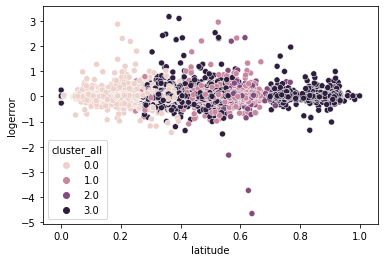

In [47]:
sns.scatterplot(x=X.latitude, y=y_train.logerror, hue=(X.cluster_all))

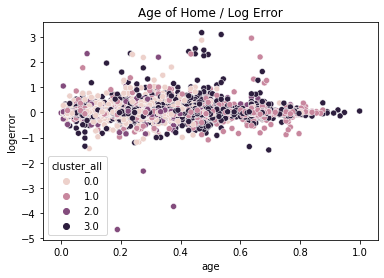

In [48]:
sns.scatterplot(x=X.age, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('Age of Home / Log Error')
plt.show()

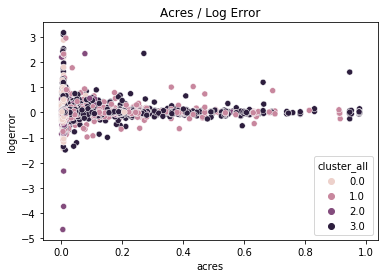

In [49]:
sns.scatterplot(x=X.acres, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('Acres / Log Error')
plt.show()

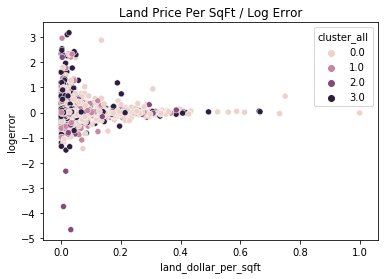

In [50]:
sns.scatterplot(x=X.land_dollar_per_sqft, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('Land Price Per SqFt / Log Error')
plt.show()

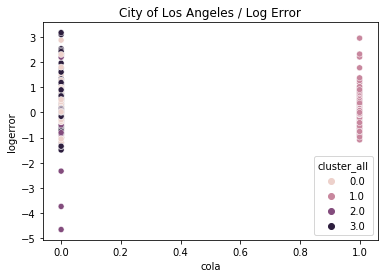

In [51]:
sns.scatterplot(x=X.cola, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('City of Los Angeles / Log Error')
plt.show()

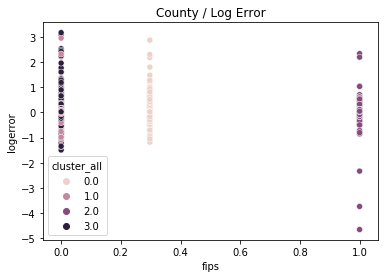

In [52]:
sns.scatterplot(x=X.fips, y=y_train.logerror, hue=(X.cluster_all))
sns.color_palette("husl", 8)
plt.title('County / Log Error')
plt.show()

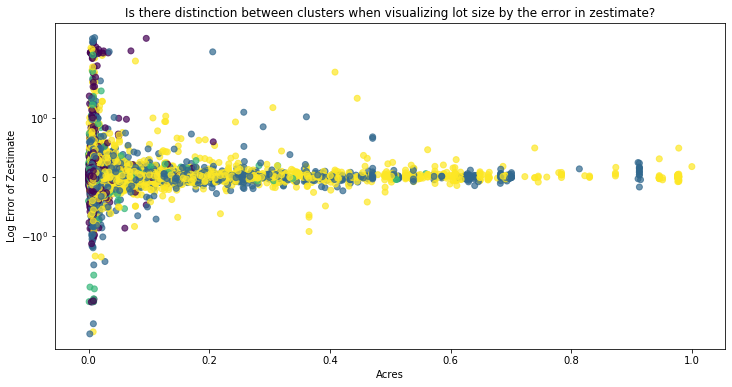

In [53]:
plt.figure(figsize=(12,6))
plt.scatter(y=y_train.logerror, x=X_train.acres, c=X.cluster_all, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Acres')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing lot size by the error in zestimate?')
plt.show()

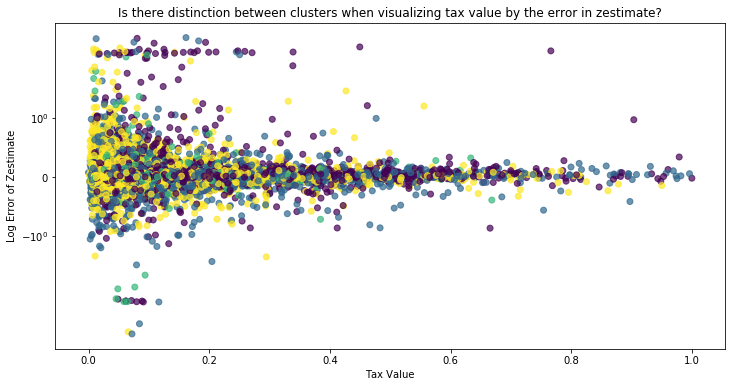

In [54]:
plt.figure(figsize=(12,6))
plt.scatter(y=y_train.logerror, x=X_train.tax_value, c=X.cluster_all, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Tax Value')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing tax value by the error in zestimate?')
plt.show()

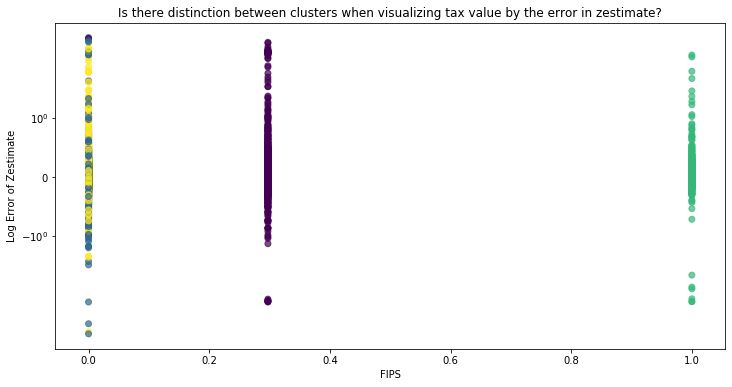

In [55]:
plt.figure(figsize=(12,6))
plt.scatter(y=y_train.logerror, x=X_train.fips, c=X.cluster_all, alpha=.7)
plt.yscale('symlog')
plt.xlabel('FIPS')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing tax value by the error in zestimate?')
plt.show()

## <font color = 'red'> Cluster on Land Columns (size, cost, age)

In [56]:
X1 = X_train[['land_dollar_per_sqft', 'tax_value', 'age']]
X2 = X_validate[['land_dollar_per_sqft', 'tax_value', 'age']]
X3 = X_test[['land_dollar_per_sqft', 'tax_value', 'age']]
# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([2, 2, 3, ..., 2, 3, 0], dtype=int32)

In [57]:
X_train['cluster_sca'] = kmeans.predict(X1)
X_validate['cluster_sca'] = kmeans.predict(X2)
X_test['cluster_sca'] = kmeans.predict(X3)

In [58]:
sca_centers=kmeans.cluster_centers_

In [59]:
X_train.head(1)

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all,cluster_sca
0,0.166667,0.333333,0.088894,0.0,0.589381,0.669595,0.456522,0.057297,0.17724,0.175609,0.154379,0.008115,0.109072,0.062633,0.166667,0.0,3,2


## <font color = 'red'> Cluster on Location Columns (latitude, longitude, cola, fips)

In [60]:
X1 = X_train[['latitude', 'longitude', 'cola', 'fips']]
X2 = X_validate[['latitude', 'longitude', 'cola', 'fips']]
X3 = X_test[['latitude', 'longitude', 'cola', 'fips']]
# Make the kmeans object
kmeans = KMeans(n_clusters=3)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

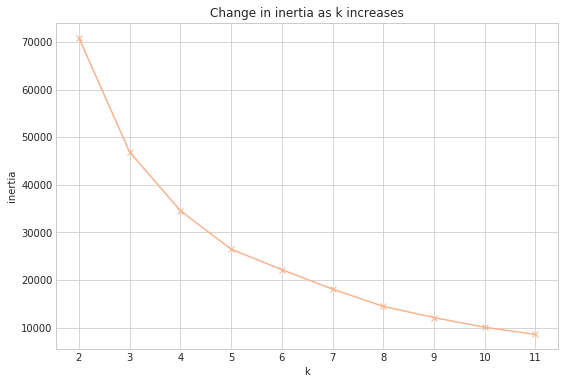

In [61]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [62]:
X_train['cluster_location'] = kmeans.predict(X1)
X_validate['cluster_location'] = kmeans.predict(X2)
X_test['cluster_location'] = kmeans.predict(X3)

In [63]:
loc_centers= kmeans.cluster_centers_

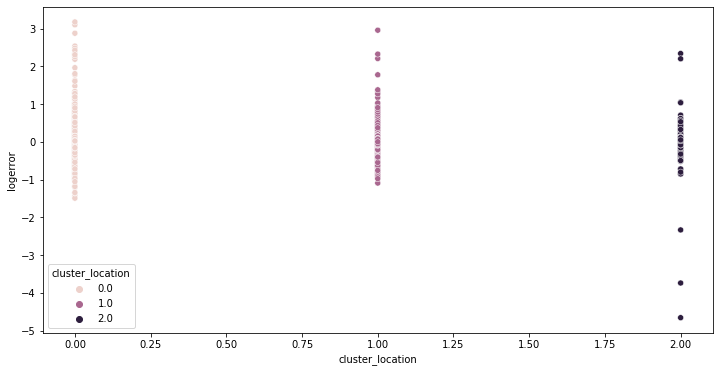

In [64]:
plt.figure(figsize=(12,6))
p= sns.scatterplot(x=X_train.cluster_location, y=y_train.logerror, hue=X_train.cluster_location)
p

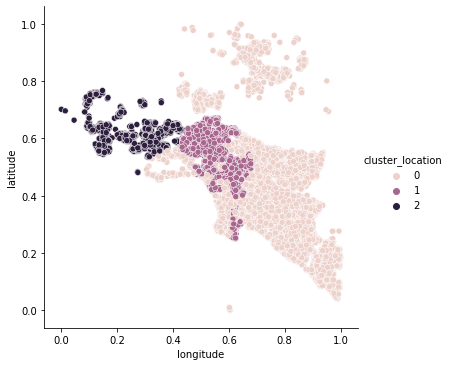

In [65]:
sns.relplot(x="longitude", y="latitude", hue="cluster_location", data=X_train)

## <font color = 'red'> Cluster on Tax (structure_tax_value, land_tax_value, taxamount)

In [66]:
X1 = X_train[['structure_tax_value', 'land_tax_value', 'taxamount']]
X2 = X_validate[['structure_tax_value', 'land_tax_value', 'taxamount']]
X3 = X_test[['structure_tax_value', 'land_tax_value', 'taxamount']]

# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([1, 0, 2, ..., 2, 2, 0], dtype=int32)

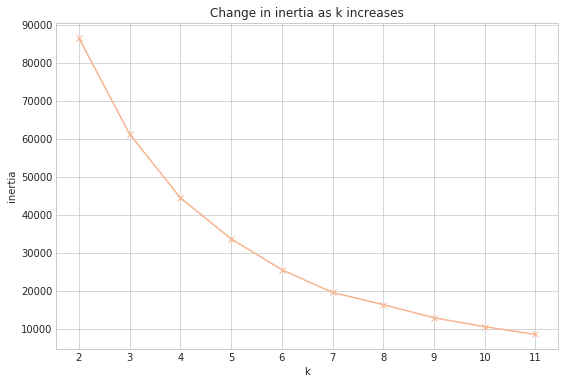

In [67]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [68]:
X_train['cluster_tax'] = kmeans.predict(X1)
X_validate['cluster_tax'] = kmeans.predict(X2)
X_test['cluster_tax'] = kmeans.predict(X3)

In [69]:
kmeans.cluster_centers_

array([[0.03229849, 0.02253039, 0.03483667],
       [0.1059334 , 0.14547106, 0.15133098],
       [0.0569755 , 0.07587868, 0.08104518],
       [0.34025813, 0.53194844, 0.52077188],
       [0.1913843 , 0.28399327, 0.28194188]])

In [70]:
X_train.head(1)

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all,cluster_sca,cluster_location,cluster_tax
0,0.166667,0.333333,0.088894,0.0,0.589381,0.669595,0.456522,0.057297,0.17724,0.175609,0.154379,0.008115,0.109072,0.062633,0.166667,0.0,3,2,0,1


 ## <font color = 'red'> Cluster on Misc (age, acres, structure_dollar_per_sqft)

In [71]:
X1 = X_train[['age', 'acres', 'structure_dollar_per_sqft']]
X2 = X_validate[['age', 'acres', 'structure_dollar_per_sqft']]
X3 = X_test[['age', 'acres', 'structure_dollar_per_sqft']]
# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X1)

# use the thing
kmeans.predict(X1)

array([2, 2, 1, ..., 2, 1, 3], dtype=int32)

In [72]:
X_train['cluster_misc'] = kmeans.predict(X1)
X_validate['cluster_misc'] = kmeans.predict(X2)
X_test['cluster_misc'] = kmeans.predict(X3)

In [73]:
kmeans.cluster_centers_

array([[0.64299814, 0.00820248, 0.0657042 ],
       [0.26222455, 0.0270147 , 0.07820257],
       [0.43497219, 0.01078493, 0.05914163],
       [0.105073  , 0.01643655, 0.1110488 ],
       [0.27412406, 0.44407922, 0.08981219]])

In [74]:
X_train.head(1)

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cola,cluster_all,cluster_sca,cluster_location,cluster_tax,cluster_misc
0,0.166667,0.333333,0.088894,0.0,0.589381,0.669595,0.456522,0.057297,0.17724,0.175609,0.154379,0.008115,0.109072,0.062633,0.166667,0.0,3,2,0,1,2


In [75]:
clusters= X_train[['cluster_all','cluster_sca','cluster_location', 'cluster_tax', 'cluster_misc']]
clusters.head(3)

,cluster_all,cluster_sca,cluster_location,cluster_tax,cluster_misc
0,3,2,0,1,2
1,1,2,1,0,2
2,3,3,0,2,1


# Hypothesis Testing

In [76]:
X_train = X_train.astype({'cluster_sca': 'category', 'cluster_location': 'category', 'cluster_tax': 'category','cluster_misc': 'category'})

dummy_df = pd.get_dummies(X_train[['cluster_sca','cluster_location','cluster_tax','cluster_misc']], dummy_na=False, drop_first=[True, True])

In [77]:
X_validate = X_validate.astype({'cluster_sca': 'category', 'cluster_location': 'category', 'cluster_tax': 'category','cluster_misc': 'category'})
X_test = X_test.astype({'cluster_sca': 'category', 'cluster_location': 'category', 'cluster_tax': 'category','cluster_misc': 'category'})

In [78]:
dummy_df2 = pd.get_dummies(X_validate[['cluster_sca','cluster_location','cluster_tax','cluster_misc']], dummy_na=False, drop_first=[True, True])
dummy_df3 = pd.get_dummies(X_test[['cluster_sca','cluster_location','cluster_tax','cluster_misc']], dummy_na=False, drop_first=[True, True])

In [79]:
# append dummy df cols to the original df. 
X_train = pd.concat([X_train, dummy_df], axis=1)
X_validate = pd.concat([X_validate, dummy_df2], axis=1)
X_test = pd.concat([X_test, dummy_df3], axis=1)

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38835 entries, 0 to 38834
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bathrooms                  38835 non-null  float64 
 1   bedrooms                   38835 non-null  float64 
 2   square_feet                38835 non-null  float64 
 3   fips                       38835 non-null  float64 
 4   latitude                   38835 non-null  float64 
 5   longitude                  38835 non-null  float64 
 6   age                        38835 non-null  float64 
 7   structure_tax_value        38835 non-null  float64 
 8   tax_value                  38835 non-null  float64 
 9   land_tax_value             38835 non-null  float64 
 10  taxamount                  38835 non-null  float64 
 11  acres                      38835 non-null  float64 
 12  structure_dollar_per_sqft  38835 non-null  float64 
 13  land_dollar_per_sqft       3883

𝐻0 : A properties land features has no correlation with log error.<br>
𝐻𝑎 : Properties with 

 import scipy.stats as stats
α = 0.05
null_hypothesis = "a properties land features has no correlation with log error."
F, p = stats.f_oneway(
                    y_train.logerror[X_train.cluster_sca == 0],
                    y_train.logerror[X_train.cluster_sca == 1],
                    y_train.logerror[X_train.cluster_sca == 2],
                    y_train.logerror[X_train.cluster_sca == 3],
                    y_train.logerror[X_train.cluster_sca == 4])

if p >  α:
    print("We fail to reject the null hypothesis. The null hypothesis is that", null_hypothesis)
else:
    print("We reject the null hypothesis that", null_hypothesis)

print('Anova Test Results on Tax Cluster')
print('F-value:',F)
print('P-value:',p)

In [81]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips', 'latitude', 'longitude',
       'age', 'structure_tax_value', 'tax_value', 'land_tax_value',
       'taxamount', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bath_bed_ratio', 'cola', 'cluster_all',
       'cluster_sca', 'cluster_location', 'cluster_tax', 'cluster_misc',
       'cluster_sca_1', 'cluster_sca_2', 'cluster_sca_3', 'cluster_sca_4',
       'cluster_location_1', 'cluster_location_2', 'cluster_tax_1',
       'cluster_tax_2', 'cluster_tax_3', 'cluster_tax_4', 'cluster_misc_1',
       'cluster_misc_2', 'cluster_misc_3', 'cluster_misc_4'],
      dtype='object')

<a id='Model'></a>

## Model

[back to top](#back)

### Feature Engineering

In [82]:
#SelectKBest

skb_features = wrangle.select_kbest(X_train, y_train, 5)
skb_features


['bathrooms', 'bedrooms', 'square_feet', 'cola', 'cluster_location_1']

In [83]:
# RFE

In [84]:
rfe_features = wrangle.rfe(X_train, y_train, 5)
rfe_features

['bathrooms', 'bedrooms', 'square_feet', 'taxamount', 'cluster_sca_4']

### Creating a Baseline

In [85]:
# 1. Predict logerror_mean
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_logerrorpred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of tax_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

# 4. RMSE of tax_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** (1/2)
rmse_validate_baseline = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** (1/2)
print("RMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate_baseline)

RMSE using Mean
Train/In-Sample:  0.16471743733642322 
Validate/Out-of-Sample:  0.16847821920209324
RMSE using Median
Train/In-Sample:  0.165016885314455 
Validate/Out-of-Sample:  0.16880432248345412


In [86]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

#### Linear Regression Model (OLS Regressor)

In [87]:
# Creating dataframe of cluster_location_1 for modeling
X_train_cl1 = pd.DataFrame(X_train.cluster_location_1)
X_validate_cl1 = pd.DataFrame(X_validate.cluster_location_1)
X_test_cl1 = pd.DataFrame(X_test.cluster_location_1)

In [88]:
#make the thing
lm = LinearRegression(normalize=True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

lm.fit(X_train_cl1, y_train.logerror)

# predict train
# 
# use the thing!
# 
y_train['logerror_pred_lm'] = lm.predict(X_train_cl1)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_cl1)

# evaluate: rmse
rmse_validate_ols = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16464462486784714 
Validation/Out-of-Sample:  0.16850981826728345


In [89]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_ols,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.168478,0.000000
1,OLS Regressor,0.168510,-0.000375


#### Lasso Lars

In [90]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_cl1, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_cl1)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_cl1)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)

RMSE for Lasso + Lars
Training/In-Sample:  0.16471743733642322 
Validation/Out-of-Sample:  0.16847821920209324


In [91]:
metric_df = metric_df.append({
    'model': 'Lasso LARS', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.168478,0.000000e+00
1,OLS Regressor,0.168510,-3.752293e-04
2,Lasso LARS,0.168478,1.110223e-16


#### Polynomial Regression

In [96]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree = pf.fit_transform(X_train_cl1)

# transform X_validate_scaled & X_test_scaled
X_validate_degree = pf.transform(X_validate_cl1)
X_test_degree =  pf.transform(X_test_cl1)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_cl1, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_cl1)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_cl1)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16471743733642322 
Validation/Out-of-Sample:  0.16847821920209324


In [97]:
metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,0.168478,0.000000e+00
1,OLS Regressor,0.168510,-3.752293e-04
2,Lasso LARS,0.168478,1.110223e-16
3,Quadratic Model,0.028396,-3.752293e-04


#### Running on Test

In [98]:
# predict on test
y_test['logerror_pred_lm2'] = lm2.predict(X_test_cl1)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2) ** (1/2)

print("RMSE for GLM Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for GLM Model using LinearRegression
Out-of-Sample Performance:  0.16038474864220675


<a id='Concl'></a>

## Conclusion

[back to top](#back)